In [1]:
from pathlib import Path
import sys
import os


project_root = str(Path.cwd().parent.resolve())

if project_root not in sys.path:
    sys.path.append(project_root)

from src.dataset import GTSRBDataset

print(f"Project root added to path: {project_root}")

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Project root added to path: /Users/kaankoc/Projects/gtsrb_classifier


In [2]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    # 1. Python random
    random.seed(seed)
    
    # 2. NumPy (used for your data indices split)
    np.random.seed(seed)
    
    # 3. PyTorch (used for weight initialization)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Forces deterministic algorithms
    torch.backends.cudnn.benchmark = False
    
    print(f"Random seed set to {seed}")

# Call it immediately
set_seed(42)

Random seed set to 42


In [3]:
# --- 1. Configuration ---

BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
SHUFFLE_DATASET = True
RANDOM_SEED = 42

CSV_PATH = '../data/GTSRB/Train.csv' 
ROOT_DIR = '../data/GTSRB'

In [4]:
# --- 2. Define Transformations ---

# Training: Includes Data Augmentation (Rotation, Shift, Color Jitter)
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # Normalize with standard ImageNet values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation: Clean images (No augmentation, just resizing and normalization)
val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# --- 3. Create Datasets and Split ---

# Instantiating dataset once with train_transforms, and once with val_transforms.
# For validation, disable ROI cropping to ensure truly clean images
train_dataset_full = GTSRBDataset(csv_file=CSV_PATH, root_dir=ROOT_DIR, transform=train_transform, use_roi=True)
val_dataset_full   = GTSRBDataset(csv_file=CSV_PATH, root_dir=ROOT_DIR, transform=val_transform, use_roi=False)

# Create split indices
dataset_size = len(train_dataset_full)
indices = list(range(dataset_size))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))

if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Create Samplers
# Samplers tell the DataLoader which indices to pick
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [6]:
# --- 4. Create DataLoaders ---

train_loader = DataLoader(
    train_dataset_full, 
    batch_size=BATCH_SIZE, 
    sampler=train_sampler,
    num_workers=4  
)

val_loader = DataLoader(
    val_dataset_full, 
    batch_size=BATCH_SIZE, 
    sampler=val_sampler,
    num_workers=4  
)

print(f"Total Training Samples: {len(train_indices)}")
print(f"Total Validation Samples: {len(val_indices)}")

Total Training Samples: 31368
Total Validation Samples: 7841


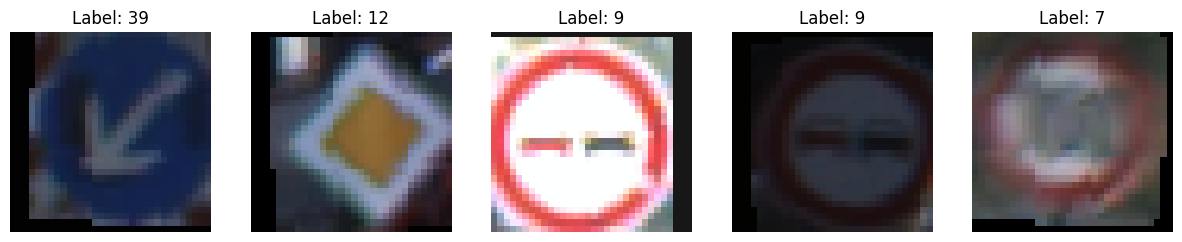

In [7]:
# Function to un-normalize and display an image
def imshow(img):
    # Undo normalization for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img.numpy().transpose((1, 2, 0)) # Convert from Tensor image
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first 5 images in the batch
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i])
    plt.title(f"Label: {labels[i].item()}")
plt.show()

--- Validation Images (Should look clean) ---


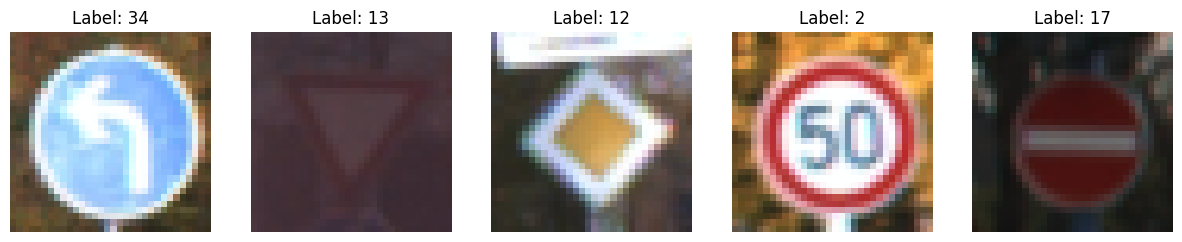

In [8]:
# Get a batch from the VALIDATION loader (should be clean)
val_iter = iter(val_loader)
images, labels = next(val_iter)

# Plot the first 5 images
plt.figure(figsize=(15, 5))
print("--- Validation Images (Should look clean) ---")
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i]) # Reuse the imshow function from before
    plt.title(f"Label: {labels[i].item()}")
plt.show()

In [12]:
import torch.optim as optim
import torch.nn as nn
import time

# 1. Import your model
from src.model import GTSRBNet

# 2. Detect Device (Crucial for Mac speed!)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {device}")

# 3. Initialize Model
model = GTSRBNet(num_classes=43).to(device)

# 4. Define Loss Function and Optimizer
# CrossEntropyLoss is the standard for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam is a smart optimizer that adjusts learning rates automatically
# lr=0.001 is a standard starting point
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# 2. Add a Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



Training on device: mps
Loading pre-trained ResNet18 weights...


In [13]:
num_epochs = 15 # You can increase this later if needed
best_acc = 0.0 # To keep track of the best validation accuracy

# Lists to keep track of progress for plotting later
train_losses = []
val_losses = []
val_accuracies = []

print("Starting Training...")
start_time = time.time()

for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train() # Set model to training mode (enables Dropout)
    running_loss = 0.0
    
    for images, labels in train_loader:
        # Move data to the GPU/MPS
        images, labels = images.to(device), labels.to(device)
        
        # 1. Zero the parameter gradients
        optimizer.zero_grad()
        
        # 2. Forward Pass (Predict)
        outputs = model(images)
        
        # 3. Calculate Loss (How wrong was it?)
        loss = criterion(outputs, labels)
        
        # 4. Backward Pass (Calculate corrections)
        loss.backward()
        
        # 5. Optimize (Update weights)
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average training loss for this epoch
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # --- VALIDATION PHASE ---
    model.eval() # Set model to evaluation mode (disables Dropout)
    val_loss = 0.0
    correct = 0
    total = 0
    
    # We don't need gradients for validation (saves memory)
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_acc)
    
    # Print statistics for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_acc:.2f}%")
    
    # --- Save Best Model ---
    # Initialize best_acc = 0.0 before the loop
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), '../models/gtsrb_best_model.pth')
        print(f"   --> New best model saved! ({best_acc:.2f}%)")
        
    # --- NEW: Update Learning Rate ---
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"   --> Current Learning Rate: {current_lr}")

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes.")

Starting Training...
Epoch [1/15] Train Loss: 0.3220 | Val Loss: 0.6203 | Val Acc: 83.36%
   --> New best model saved! (83.36%)
   --> Current Learning Rate: 0.001
Epoch [2/15] Train Loss: 0.0564 | Val Loss: 0.6854 | Val Acc: 83.27%
   --> Current Learning Rate: 0.001
Epoch [3/15] Train Loss: 0.0497 | Val Loss: 0.7337 | Val Acc: 79.86%
   --> Current Learning Rate: 0.001
Epoch [4/15] Train Loss: 0.0444 | Val Loss: 0.7683 | Val Acc: 80.32%
   --> Current Learning Rate: 0.001
Epoch [5/15] Train Loss: 0.0359 | Val Loss: 0.5059 | Val Acc: 86.84%
   --> New best model saved! (86.84%)
   --> Current Learning Rate: 0.0001
Epoch [6/15] Train Loss: 0.0085 | Val Loss: 0.3999 | Val Acc: 89.02%
   --> New best model saved! (89.02%)
   --> Current Learning Rate: 0.0001
Epoch [7/15] Train Loss: 0.0036 | Val Loss: 0.3780 | Val Acc: 89.45%
   --> New best model saved! (89.45%)
   --> Current Learning Rate: 0.0001
Epoch [8/15] Train Loss: 0.0026 | Val Loss: 0.3483 | Val Acc: 90.41%
   --> New best mode

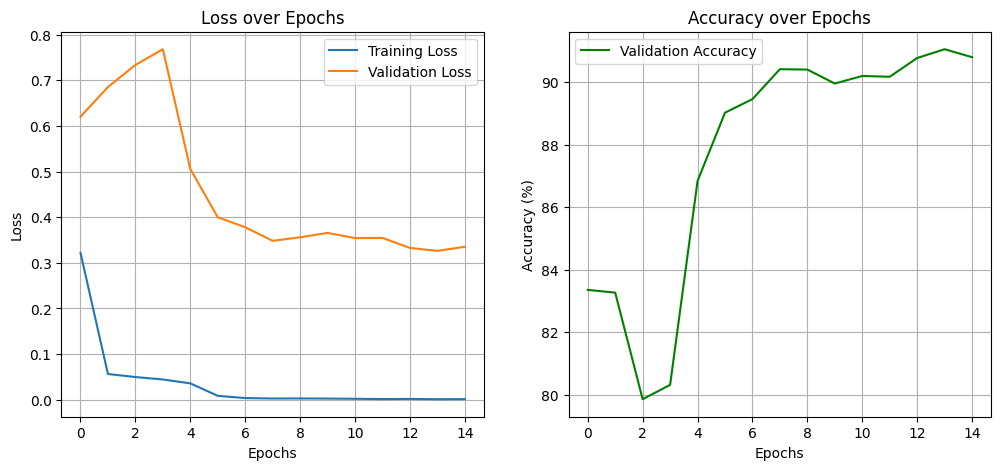

In [14]:
# Plotting the Training vs Validation Loss
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()